# 0. Подготовка рабочего пространства

In [ ]:
import numpy as np
import pandas as pd

import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/kaggle/Titanic/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/kaggle/Titanic/test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Анализ данных и обработка данных


In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


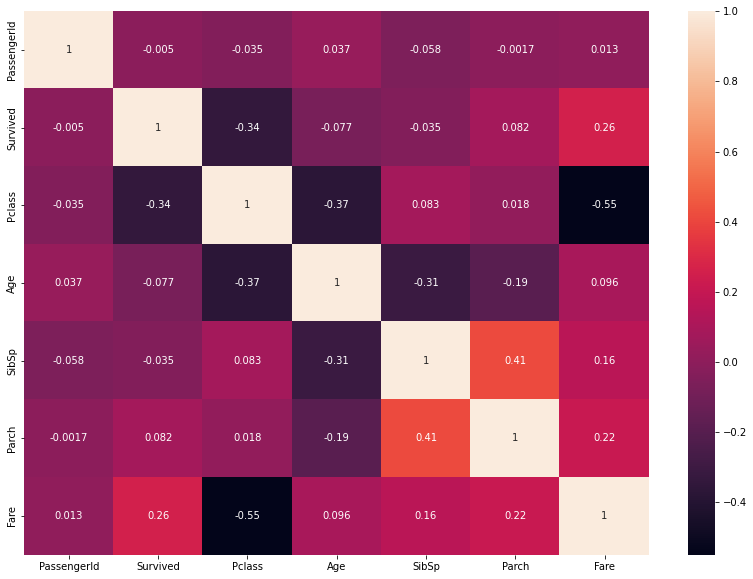

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(train_data.corr(), annot=True)

Проверка на дупликаты:

In [ ]:
dup = train_data[train_data.duplicated()].shape[0]
dup

0

Анализ пропущенных значений:

In [ ]:
pd.DataFrame(data = [train_data.isna().sum()/train_data.shape[0]*100, 
                     test_data.isna().sum()/test_data.shape[0]*100], 
             index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Train Null (%),Test Null (%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


# Age


In [ ]:
train_data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

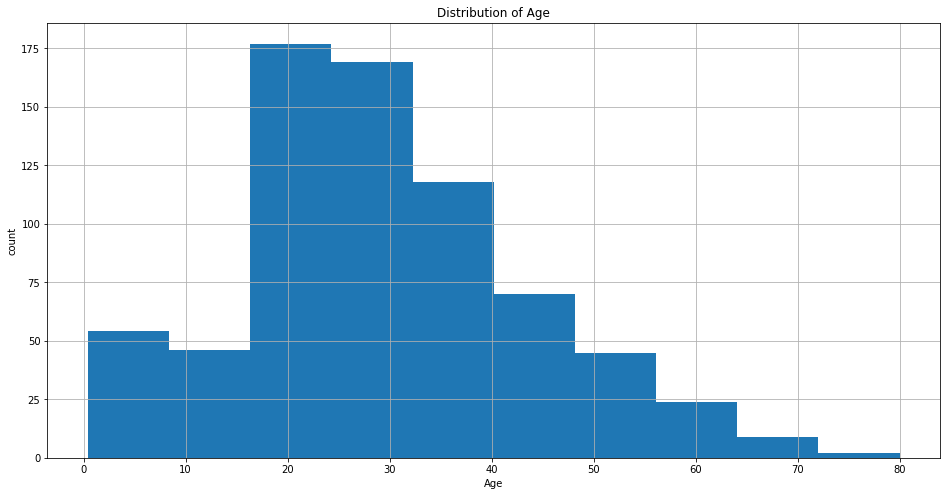

In [ ]:
plt.figure(figsize = (16, 8))

train_data['Age'].hist(bins = 10)
plt.ylabel('count')
plt.xlabel('Age')

plt.title('Distribution of Age')
plt.show()

In [ ]:
train_data.loc[(train_data['Age'] <= 1)] = 1
test_data.loc[(test_data['Age'] <= 1)] = 1

In [ ]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
test_data['Age'] = test_data['Age'].fillna(train_data['Age'].mean())

In [ ]:
train_data['Age'].isna().sum()

0

In [ ]:
train_data['Age'].value_counts()

29.701681    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
14.500000      1
70.500000      1
12.000000      1
36.500000      1
74.000000      1
Name: Age, Length: 84, dtype: int64

# Title

In [ ]:
train_data["Title"] = train_data["Name"].str.extract('([A-Za-z]+)\.')
test_data["Title"] = test_data["Name"].str.extract('([A-Za-z]+)\.')

train_data["Title"].value_counts()

Mr          517
Miss        178
Mrs         125
Master       30
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [ ]:
def convert_title(title):
    if title in ["Ms", "Mile", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs"]:
        return "Mrs"
    elif title == "Mr":
        return "Mr"
    elif title == "Master":
        return "Master"
    else:
        return "Other"
        
train_data["Title"] = train_data["Title"].map(convert_title)
test_data["Title"] = test_data["Title"].map(convert_title)

train_data["Title"].value_counts()

Mr        517
Miss      179
Mrs       126
Other      39
Master     30
Name: Title, dtype: int64

# Удаляем ненужные столбцы

In [ ]:
train_data.drop("PassengerId", axis=1, inplace=True)
test_data.drop("PassengerId", axis=1, inplace=True)

In [ ]:
train_data.drop("Cabin", axis=1, inplace=True)
test_data.drop("Cabin", axis=1, inplace=True)

In [ ]:
train_data.drop("Name", axis=1, inplace=True)
test_data.drop("Name", axis=1, inplace=True)

In [ ]:
train_data.drop("Ticket", axis=1, inplace=True)
test_data.drop("Ticket", axis=1, inplace=True)

In [ ]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


# Изменяем категориальные переменные

In [ ]:
train_data = pd.get_dummies(train_data, prefix=["Sex", "Embarked", "Title"])
test_data = pd.get_dummies(test_data, prefix=["Sex", "Embarked", "Title"])

In [ ]:
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_1,Sex_female,Sex_male,Embarked_1,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,22.0,1,0,7.2500,0,0,1,0,0,0,1,0,0,1,0,0
1,1,1,38.0,1,0,71.2833,0,1,0,0,1,0,0,0,0,0,1,0
2,1,3,26.0,0,0,7.9250,0,1,0,0,0,0,1,0,1,0,0,0
3,1,1,35.0,1,0,53.1000,0,1,0,0,0,0,1,0,0,0,1,0
4,0,3,35.0,0,0,8.0500,0,0,1,0,0,0,1,0,0,1,0,0


# Построение моделей

In [ ]:
x_train = train_data.drop('Survived', axis = 1)
y_train = train_data.Survived

x_test = test_data.copy()

In [ ]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier()
}

results = dict()
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, x_train_scaled, y_train, cv=5,
        scoring=('accuracy')
    )

    results[name] = cv_results['test_score'].mean()
    
results

{'KNN': 0.8114556525014123,
 'LR': 0.8237963718536188,
 'DT': 0.7878727010231623,
 'RF': 0.806973824618668,
 'SVM': 0.8271483271608814,
 'MLP': 0.8159939740129308,
 'XGB': 0.8327788588286987,
 'LGBM': 0.8182160567447117}

In [ ]:
xgb= XGBClassifier(random_state=0)
params = {
    "boosting_type": ["gbtree", "gblinear", "dart"],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [10, 50, 100, 300]
}
clf = GridSearchCV(xgb, params, cv=10)
clf.fit(x_train_scaled, y_train)
print("Best hyperparameter:", clf.best_params_)

Best hyperparameter: {'boosting_type': 'gbtree', 'learning_rate': 0.05, 'n_estimators': 300}


In [ ]:
y_pred = clf.predict(x_train_scaled)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       547
           1       0.90      0.82      0.86       344

    accuracy                           0.90       891
   macro avg       0.90      0.88      0.89       891
weighted avg       0.90      0.90      0.89       891



In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/kaggle/Titanic/test.csv')

In [247]:
y_pred = clf.predict(x_test_scaled)

submission = pd.DataFrame({
         "PassengerId": test_data["PassengerId"],
         "Survived": y_pred
          })
submission.to_csv('/content/drive/My Drive/kaggle/Titanic/titanic_subm.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
